In [1]:
import pandas
import math
import re
import matplotlib.pyplot as plt
import numpy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.colors as mcolors

In [2]:
SKEMPI = pandas.read_csv("skempi_v2.csv", sep = ";")
PDBList = ("1JTG", "5E9D", "3SZK", "3BN9", "2J0T", "1KTZ", "3SGB", "3MZG", "1DAN", "1VFB", "1OGA")
PDBList2 = ("1JTG_A_B", "5E9D_AB_CDE", "3SZK_AB_C", "3BN9_B_CD", "2J0T_A_D",
           "1KTZ_A_B", "3SGB_E_I", "3MZG_A_B", "1DAN_HL_UT", "1VFB_AB_C", "1OGA_ABC_DE")

filtered_SKEMPI = SKEMPI[SKEMPI["#Pdb"].isin(PDBList2)]
filtered_df = filtered_SKEMPI[filtered_SKEMPI['Mutation(s)_cleaned'].str.len() <= 7]
cols_by_pdb = ["red", "orange", "yellow", "green", "blue", "purple", "gray", "black", "brown", "pink", "cyan"]
cols_by_group = ["red", "black", "blue", "green"]

In [3]:
def ddG(aff_wt, aff_mut):
    constant = (8.314/4184)*(273.15 + 25.0)
    return constant * (math.log(aff_mut) - math.log(aff_wt))

In [4]:
ddG_1DAN = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_1DAN_af2.txt", sep = " ")
ddG_1JTG = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_1JTG_af2.txt", sep = " ")
ddG_1KTZ = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_1KTZ_af2.txt", sep = " ")
ddG_1OGA = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_1OGA_af2.txt", sep = " ")
ddG_1VFB = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_1VFB_af2.txt", sep = " ")
ddG_2J0T = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_2J0T_af2.txt", sep = " ")
ddG_3BN9 = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_3BN9_af2.txt", sep = " ")
ddG_3MZG = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_3MZG_af2.txt", sep = " ")
ddG_3SGB = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_3SGB_af2.txt", sep = " ")
ddG_3SZK = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_3SZK_af2.txt", sep = " ")
ddG_5E9D = pandas.read_csv("AF2_ddGs/prism_rosetta_XXX_5E9D_af2.txt", sep = " ")
ddG_1DAN_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_1DAN_af3.txt", sep = " ")
ddG_1JTG_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_1JTG_af3.txt", sep = " ")
ddG_1KTZ_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_1KTZ_af3.txt", sep = " ")
ddG_1OGA_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_1OGA_af3.txt", sep = " ")
ddG_1VFB_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_1VFB_af3.txt", sep = " ")
ddG_2J0T_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_2J0T_af3.txt", sep = " ")
ddG_3BN9_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_3BN9_af3.txt", sep = " ")
ddG_3MZG_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_3MZG_af3.txt", sep = " ")
ddG_3SGB_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_3SGB_af3.txt", sep = " ")
ddG_3SZK_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_3SZK_af3.txt", sep = " ")
ddG_5E9D_af3 = pandas.read_csv("AF3_ddGs/prism_rosetta_XXX_5E9D_af3.txt", sep = " ")

In [5]:
SKEMPI_1DAN = filtered_df[filtered_df['#Pdb'].isin(["1DAN_HL_UT"])] #Special Case
SKEMPI_1JTG = filtered_df[filtered_df['#Pdb'].isin(["1JTG_A_B"])]
SKEMPI_1KTZ = filtered_df[filtered_df['#Pdb'].isin(["1KTZ_A_B"])]
SKEMPI_1OGA = filtered_df[filtered_df['#Pdb'].isin(["1OGA_ABC_DE"])]
SKEMPI_1VFB = filtered_df[filtered_df['#Pdb'].isin(["1VFB_AB_C"])]
SKEMPI_2J0T = filtered_df[filtered_df['#Pdb'].isin(["2J0T_A_D"])]
SKEMPI_3BN9 = filtered_df[filtered_df['#Pdb'].isin(["3BN9_B_CD"])]
SKEMPI_3MZG = filtered_df[filtered_df['#Pdb'].isin(["3MZG_A_B"])]
SKEMPI_3SGB = filtered_df[filtered_df['#Pdb'].isin(["3SGB_E_I"])]
SKEMPI_3SZK = filtered_df[filtered_df['#Pdb'].isin(["3SZK_AB_C"])]
SKEMPI_5E9D = filtered_df[filtered_df['#Pdb'].isin(["5E9D_AB_CDE"])] #Special Case

In [6]:
def extract_key(s):
    match = re.match(r"(.)(.)(\d+)(.)", s)
    if match:
        _, amino, pos, mut = match.groups()
        return (amino, int(pos), mut)  # Sort first by character Y, then by number
    return ("", 0)  # Fallback, if needed
custom_order = {'H': 0, 'L': 1, 'U': 2, 'T': 3}  # Lower number means higher priority

def extract_key_sp(s):
    match = re.match(r"(.)(.)(\d+)(.)", s)  # First char, sorting char, number, last char
    if match:
        _, y, num, _ = match.groups()
        return (custom_order.get(y, 99), int(num))  # Default rank 99 if char not found
    return (99, 0)  # Fallback case
strings = ["XA12C", "XB3D", "XA5E", "XB20C", "XA2C"]
sorted_strings = sorted(strings, key=extract_key)
#print(sorted_strings)
df_sorted = SKEMPI_1JTG.sort_values(by="Mutation(s)_cleaned", key=lambda col: col.map(extract_key))
#print(df_sorted)

In [7]:
def plotoutput(SKEMPI, ddG_out, title):
    SKEMPI_sorted = SKEMPI.sort_values(by="Mutation(s)_cleaned", key=lambda col: col.map(extract_key))#
    if (title == "1DAN"):
        SKEMPI_sorted = SKEMPI.sort_values(by="Mutation(s)_cleaned", key=lambda col: col.map(extract_key_sp))
    xvals = []
    yvals = []
    if (title == "1VFB"):
        xdupes = ["YB101A"]
    elif (title == "5E9D"):
        xdupes = ["TD90Q", "YD49W", "KD96Q"]
    else:
        xdupes = []
    ydupes = []
    length = len(SKEMPI)
    i = 0
    for index, row in SKEMPI_sorted.iterrows():
        cur = row["Mutation(s)_cleaned"]
        if (cur not in xdupes):
            xval = ddG(row["Affinity_wt_parsed"], row["Affinity_mut_parsed"])
            xvals.append(xval)
            xdupes.append(cur)
        i += 1
    for index, row in ddG_out.iterrows():
        if ("=" not in row["variant"] and row["variant"] != "Y208A"):
            yvals.append(row["mean_ddG"])
            ydupes.append(row["variant"])
    values = [xvals, yvals, title]
    return values

In [8]:
def plotdata(values, title, colours):
    xvals = values[0]
    yvals = values[1]
    titles = values[2]
    unique_labels = numpy.unique(titles)  # Get unique label names
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}  # Assign numbers
    numeric_labels = numpy.array([label_to_num[label] for label in titles])  # Convert to numbers
    cmap = mcolors.ListedColormap(colours)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12.0, 12.0)
    plt.scatter(xvals, yvals, c=numeric_labels, cmap=cmap)
    ax.set_xlim([-4, 12])
    ax.set_ylim([-4, 12])
    plt.xlabel("SKEMPI ddG")
    plt.ylabel("Predicted ddG")
    plt.title(title)
    if numpy.ptp(xvals) == 0:  # ptp() gives the range (max-min)
        raise ValueError("xvals must have a nonzero range for polyfit()")
    m,b = numpy.polyfit(xvals, yvals, 1)
    plt.axline((0, b), slope=m)
    regr = linear_model.LinearRegression()
    X = numpy.array(xvals).reshape(-1, 1)
    regr.fit(X, yvals)
    ypreds = regr.predict(X)
    j = 0
    while (j < len(xvals)):
        printout = str(xvals[j]) + ", "  + str(yvals[j])
       # print(printout)
        j += 1
    xpos = 5
    if (title == "5E9D"):
        xpos = 1
    plt.text(xpos, 0, "Pearson: %.3f" % numpy.corrcoef(xvals, yvals)[1][0])
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(unique_labels))]
    plt.legend(legend_labels, unique_labels, title="Categories")
    plt.show()

In [9]:
_1DAN = plotoutput(SKEMPI_1DAN, ddG_1DAN, "1DAN")
_1JTG = plotoutput(SKEMPI_1JTG, ddG_1JTG, "1JTG")
_1KTZ = plotoutput(SKEMPI_1KTZ, ddG_1KTZ, "1KTZ")
_1OGA = plotoutput(SKEMPI_1OGA, ddG_1OGA, "1OGA")
_1VFB = plotoutput(SKEMPI_1VFB, ddG_1VFB, "1VFB")
_2J0T = plotoutput(SKEMPI_2J0T, ddG_2J0T, "2J0T")
_3BN9 = plotoutput(SKEMPI_3BN9, ddG_3BN9, "3BN9")
_3MZG = plotoutput(SKEMPI_3MZG, ddG_3MZG, "3MZG")
_3SGB = plotoutput(SKEMPI_3SGB, ddG_3SGB, "3SGB")
_3SZK = plotoutput(SKEMPI_3SZK, ddG_3SZK, "3SZK")
_5E9D = plotoutput(SKEMPI_5E9D, ddG_5E9D, "5E9D")

_1DAN_3 = plotoutput(SKEMPI_1DAN, ddG_1DAN_af3, "1DAN")
_1JTG_3 = plotoutput(SKEMPI_1JTG, ddG_1JTG_af3, "1JTG")
_1KTZ_3 = plotoutput(SKEMPI_1KTZ, ddG_1KTZ_af3, "1KTZ")
_1OGA_3 = plotoutput(SKEMPI_1OGA, ddG_1OGA_af3, "1OGA")
_1VFB_3 = plotoutput(SKEMPI_1VFB, ddG_1VFB_af3, "1VFB")
_2J0T_3 = plotoutput(SKEMPI_2J0T, ddG_2J0T_af3, "2J0T")
_3BN9_3 = plotoutput(SKEMPI_3BN9, ddG_3BN9_af3, "3BN9")
_3MZG_3 = plotoutput(SKEMPI_3MZG, ddG_3MZG_af3, "3MZG")
_3SGB_3 = plotoutput(SKEMPI_3SGB, ddG_3SGB_af3, "3SGB")
_3SZK_3 = plotoutput(SKEMPI_3SZK, ddG_3SZK_af3, "3SZK")
_5E9D_3 = plotoutput(SKEMPI_5E9D, ddG_5E9D_af3, "5E9D")

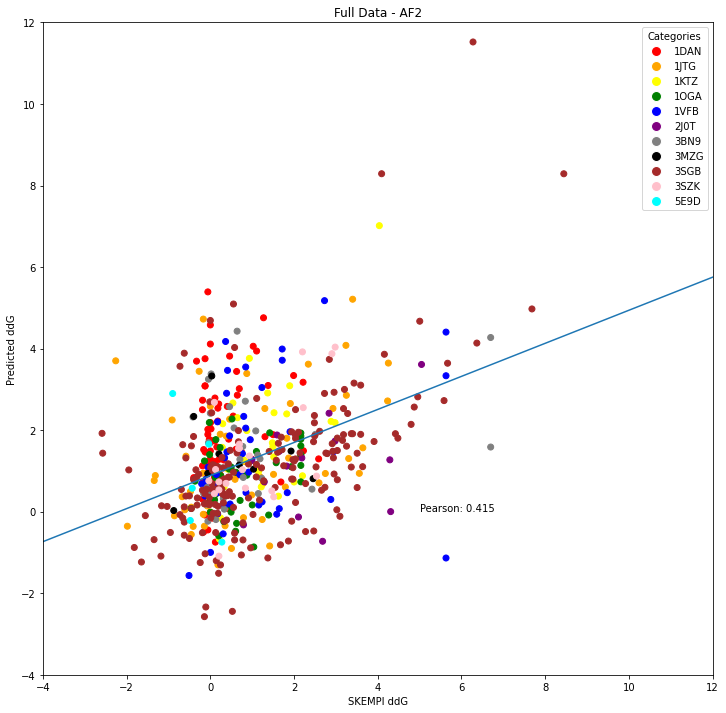

In [10]:
fullxdata = []
fullydata = []
pdbs = []
i = 0
while (i < len(_1DAN[0])):
    fullxdata.append(_1DAN[0][i])
    fullydata.append(_1DAN[1][i])
    pdbs.append("1DAN")
    i += 1
i = 0
while (i < len(_1JTG[0])):
    fullxdata.append(_1JTG[0][i])
    fullydata.append(_1JTG[1][i])
    pdbs.append("1JTG")
    i += 1
i = 0
while (i < len(_1KTZ[0])):
    fullxdata.append(_1KTZ[0][i])
    fullydata.append(_1KTZ[1][i])
    pdbs.append("1KTZ")
    i += 1
i = 0
while (i < len(_1OGA[0])):
    fullxdata.append(_1OGA[0][i])
    fullydata.append(_1OGA[1][i])
    pdbs.append("1OGA")
    i += 1
i = 0
while (i < len(_1VFB[0])):
    fullxdata.append(_1VFB[0][i])
    fullydata.append(_1VFB[1][i])
    pdbs.append("1VFB")
    i += 1
i = 0
while (i < len(_2J0T[0])):
    fullxdata.append(_2J0T[0][i])
    fullydata.append(_2J0T[1][i])
    pdbs.append("2J0T")
    i += 1
i = 0
while (i < len(_3BN9[0])):
    fullxdata.append(_3BN9[0][i])
    fullydata.append(_3BN9[1][i])
    pdbs.append("3BN9")
    i += 1
i = 0
while (i < len(_3MZG[0])):
    fullxdata.append(_3MZG[0][i])
    fullydata.append(_3MZG[1][i])
    pdbs.append("3MZG")
    i += 1
i = 0
while (i < len(_3SGB[0])):
    fullxdata.append(_3SGB[0][i])
    fullydata.append(_3SGB[1][i])
    pdbs.append("3SGB")
    i += 1
i = 0
while (i < len(_3SZK[0])):
    fullxdata.append(_3SZK[0][i])
    fullydata.append(_3SZK[1][i])
    pdbs.append("3SZK")
    i += 1
i = 0
while (i < len(_5E9D[0])):
    fullxdata.append(_5E9D[0][i])
    fullydata.append(_5E9D[1][i])
    pdbs.append("5E9D")
    i += 1
fullxdata_af2 = fullxdata
fullydata_af2 = fullydata
plotdata([fullxdata_af2, fullydata_af2, pdbs], "Full Data - AF2", cols_by_pdb)

In [13]:
print(pdbs[282])

2J0T


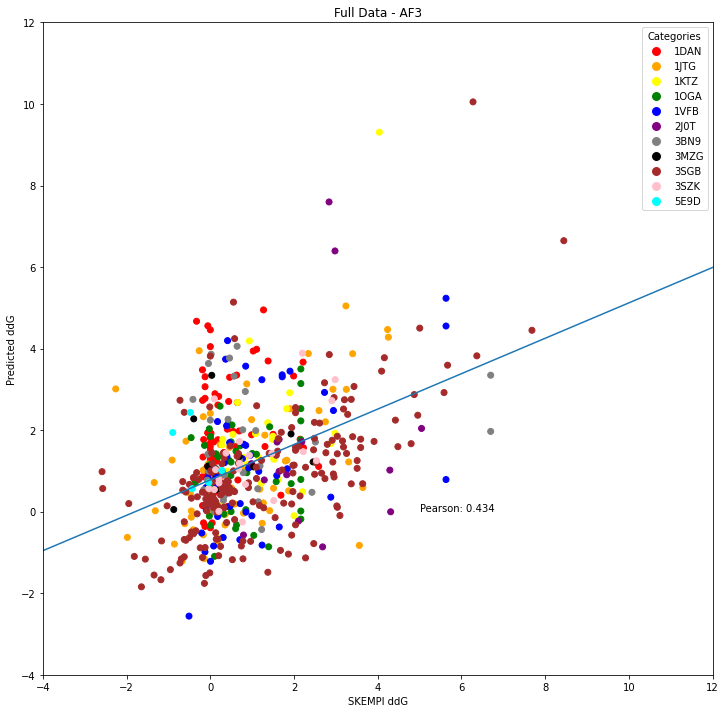

In [65]:
fullxdata = []
fullydata = []
pdbs = []
i = 0
while (i < len(_1DAN_3[0])):
    fullxdata.append(_1DAN_3[0][i])
    fullydata.append(_1DAN_3[1][i])
    pdbs.append("1DAN")
    i += 1
i = 0
while (i < len(_1JTG_3[0])):
    fullxdata.append(_1JTG_3[0][i])
    fullydata.append(_1JTG_3[1][i])
    pdbs.append("1JTG")
    i += 1
i = 0
while (i < len(_1KTZ_3[0])):
    fullxdata.append(_1KTZ_3[0][i])
    fullydata.append(_1KTZ_3[1][i])
    pdbs.append("1KTZ")
    i += 1
i = 0
while (i < len(_1OGA_3[0])):
    fullxdata.append(_1OGA_3[0][i])
    fullydata.append(_1OGA_3[1][i])
    pdbs.append("1OGA")
    i += 1
i = 0
while (i < len(_1VFB_3[0])):
    fullxdata.append(_1VFB_3[0][i])
    fullydata.append(_1VFB_3[1][i])
    pdbs.append("1VFB")
    i += 1
i = 0
while (i < len(_2J0T_3[0])):
    fullxdata.append(_2J0T_3[0][i])
    fullydata.append(_2J0T_3[1][i])
    pdbs.append("2J0T")
    i += 1
i = 0
while (i < len(_3BN9_3[0])):
    fullxdata.append(_3BN9_3[0][i])
    fullydata.append(_3BN9_3[1][i])
    pdbs.append("3BN9")
    i += 1
i = 0
while (i < len(_3MZG_3[0])):
    fullxdata.append(_3MZG_3[0][i])
    fullydata.append(_3MZG_3[1][i])
    pdbs.append("3MZG")
    i += 1
i = 0
while (i < len(_3SGB_3[0])):
    fullxdata.append(_3SGB_3[0][i])
    fullydata.append(_3SGB_3[1][i])
    pdbs.append("3SGB")
    i += 1
i = 0
while (i < len(_3SZK_3[0])):
    fullxdata.append(_3SZK_3[0][i])
    fullydata.append(_3SZK_3[1][i])
    pdbs.append("3SZK")
    i += 1
i = 0
while (i < len(_5E9D_3[0])):
    fullxdata.append(_5E9D_3[0][i])
    fullydata.append(_5E9D_3[1][i])
    pdbs.append("5E9D")
    i += 1
fullxdata_af3 = fullxdata
fullydata_af3 = fullydata
plotdata([fullxdata_af3, fullydata_af3, pdbs], "Full Data - AF3", cols_by_pdb)

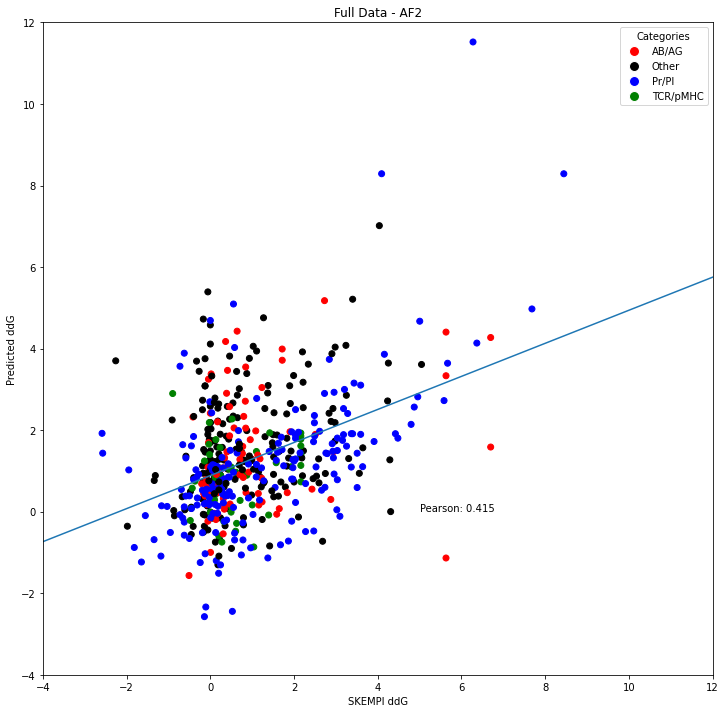

In [69]:
fullxdata = []
fullydata = []
pdbs = []
i = 0
while (i < len(_1DAN[0])):
    fullxdata.append(_1DAN[0][i])
    fullydata.append(_1DAN[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_1JTG[0])):
    fullxdata.append(_1JTG[0][i])
    fullydata.append(_1JTG[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_1KTZ[0])):
    fullxdata.append(_1KTZ[0][i])
    fullydata.append(_1KTZ[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_1OGA[0])):
    fullxdata.append(_1OGA[0][i])
    fullydata.append(_1OGA[1][i])
    pdbs.append("TCR/pMHC")
    i += 1
i = 0
while (i < len(_1VFB[0])):
    fullxdata.append(_1VFB[0][i])
    fullydata.append(_1VFB[1][i])
    pdbs.append("AB/AG")
    i += 1
i = 0
while (i < len(_2J0T[0])):
    fullxdata.append(_2J0T[0][i])
    fullydata.append(_2J0T[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_3BN9[0])):
    fullxdata.append(_3BN9[0][i])
    fullydata.append(_3BN9[1][i])
    pdbs.append("AB/AG")
    i += 1
i = 0
while (i < len(_3MZG[0])):
    fullxdata.append(_3MZG[0][i])
    fullydata.append(_3MZG[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_3SGB[0])):
    fullxdata.append(_3SGB[0][i])
    fullydata.append(_3SGB[1][i])
    pdbs.append("Pr/PI")
    i += 1
i = 0
while (i < len(_3SZK[0])):
    fullxdata.append(_3SZK[0][i])
    fullydata.append(_3SZK[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_5E9D[0])):
    fullxdata.append(_5E9D[0][i])
    fullydata.append(_5E9D[1][i])
    pdbs.append("TCR/pMHC")
    i += 1
fullxdata_af2 = fullxdata
fullydata_af2 = fullydata
plotdata([fullxdata_af2, fullydata_af2, pdbs], "Full Data - AF2", cols_by_group)

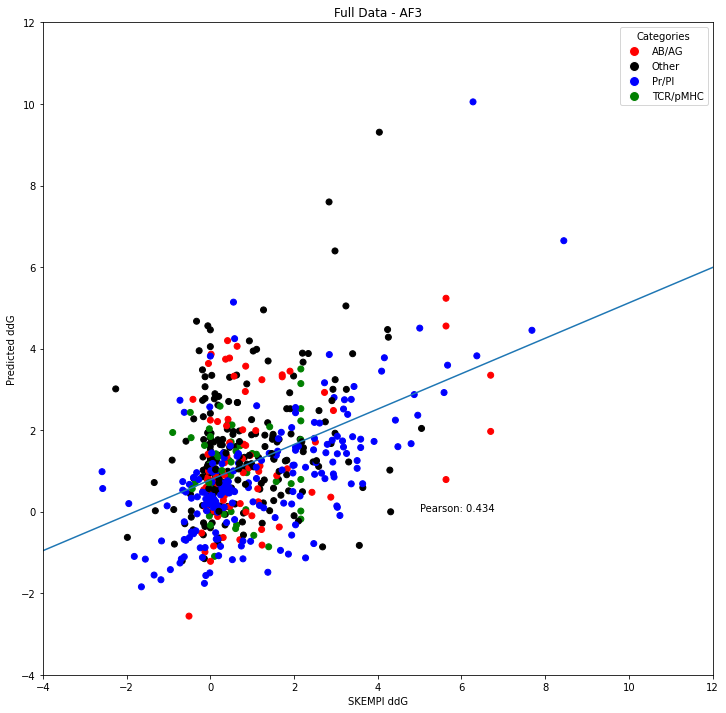

In [70]:
fullxdata = []
fullydata = []
pdbs = []
i = 0
while (i < len(_1DAN_3[0])):
    fullxdata.append(_1DAN_3[0][i])
    fullydata.append(_1DAN_3[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_1JTG_3[0])):
    fullxdata.append(_1JTG_3[0][i])
    fullydata.append(_1JTG_3[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_1KTZ_3[0])):
    fullxdata.append(_1KTZ_3[0][i])
    fullydata.append(_1KTZ_3[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_1OGA_3[0])):
    fullxdata.append(_1OGA_3[0][i])
    fullydata.append(_1OGA_3[1][i])
    pdbs.append("TCR/pMHC")
    i += 1
i = 0
while (i < len(_1VFB_3[0])):
    fullxdata.append(_1VFB_3[0][i])
    fullydata.append(_1VFB_3[1][i])
    pdbs.append("AB/AG")
    i += 1
i = 0
while (i < len(_2J0T_3[0])):
    fullxdata.append(_2J0T_3[0][i])
    fullydata.append(_2J0T_3[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_3BN9_3[0])):
    fullxdata.append(_3BN9_3[0][i])
    fullydata.append(_3BN9_3[1][i])
    pdbs.append("AB/AG")
    i += 1
i = 0
while (i < len(_3MZG_3[0])):
    fullxdata.append(_3MZG_3[0][i])
    fullydata.append(_3MZG_3[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_3SGB_3[0])):
    fullxdata.append(_3SGB_3[0][i])
    fullydata.append(_3SGB_3[1][i])
    pdbs.append("Pr/PI")
    i += 1
i = 0
while (i < len(_3SZK_3[0])):
    fullxdata.append(_3SZK_3[0][i])
    fullydata.append(_3SZK_3[1][i])
    pdbs.append("Other")
    i += 1
i = 0
while (i < len(_5E9D_3[0])):
    fullxdata.append(_5E9D_3[0][i])
    fullydata.append(_5E9D_3[1][i])
    pdbs.append("TCR/pMHC")
    i += 1
fullxdata_af3 = fullxdata
fullydata_af3 = fullydata
plotdata([fullxdata_af3, fullydata_af3, pdbs], "Full Data - AF3", cols_by_group)